<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/9_Q1_Set2_preprocessing_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color = 'cornflowerblue' size=4>Introduction</font>

In this notebook, word vectors in addition to the lexeme strings and word features derived in previous notebooks are used as a feature set.

Dimension reduction by PCA is done to bring the dataset to a reasonable size. 

After, the  features are joined to the main Q1 training set as compressed sparse matrix. 

The same preprocessing pipeline will be used to transform the Q1test set. 

This will make both datasets ready for modeling. 

Since larger dimensions are being dealt with, high-RAM option is selected:

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 54.8 gigabytes of available RAM



Importing libraries and mounting google drive:

In [5]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading Q1 train set:

In [3]:
q1train = decompress_pickle(path_name+"Q1TRAIN.pbz2") 

In [4]:
q1train.head()

,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,p_forgot_bin,simoverdiff,lang_frozenset,Datetime,delta_days,history_frac
7,1362082032,444407,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,3,3,1,1,0,0.000159,"(en, es)",2013-02-28 20:07:12,5.143600,1.000000
15,1362082130,77,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,5,5,1,1,0,0.000159,"(en, es)",2013-02-28 20:08:50,0.000891,1.000000
20,1362082274,1634777,u:dDwF,es,en,c84476c460737d9fb905dca3d35ec995,niños/niño<n><m><pl>,9,8,2,2,0,0.000159,"(en, es)",2013-02-28 20:11:14,18.921030,0.888889
21,1362082274,1708699,u:dDwF,es,en,1a913f2ded424985b9c02d0436008511,leo/leer<vblex><pri><p1><sg>,7,5,2,2,0,0.000159,"(en, es)",2013-02-28 20:11:14,19.776609,0.714286
22,1362082274,1708699,u:dDwF,es,en,38b770e66595fea718366523b4f7db3f,libro/libro<n><m><sg>,8,8,4,4,0,0.000159,"(en, es)",2013-02-28 20:11:14,19.776609,1.000000


To recap, above is a quick look at the contents of Q1TRAIN, the main dataframe. 


Loading Q1 test set:

In [6]:
q1test = decompress_pickle(path_name+"Q1TEST.pbz2")

In [7]:
q1test.head()

,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,p_forgot_bin,simoverdiff,lang_frozenset,Datetime,delta_days,history_frac
23,1362082274,444649,u:dDwF,es,en,4bdb859f599fa07dd5eecdab0acc2d34,a/a<pr>,3,3,1,1,0,0.000159,"(en, es)",2013-02-28 20:11:14,5.146400,1.000000
26,1362082274,678813,u:dDwF,es,en,64f2b1bdc5c91bb3f6ca1bb7a808b60a,quieres/querer<vblex><pri><p2><sg>,3,3,1,1,0,0.000159,"(en, es)",2013-02-28 20:11:14,7.856632,1.000000
30,1362082274,8562343,u:dDwF,es,en,edf5a0ef6c836c4df4f3b3de76ca63ba,diario/diario<n><m><sg>,3,3,3,3,0,0.000159,"(en, es)",2013-02-28 20:11:14,99.101192,1.000000
41,1362082274,6645723,u:dDwF,es,en,c2c8a202a12411858f87d4dcef5b2998,no/no<adv>,5,5,1,1,0,0.000159,"(en, es)",2013-02-28 20:11:14,76.918090,1.000000
50,1362082274,7239420,u:dDwF,es,en,81fe07635e2aa79cd36709cf1bdd81be,limón/limón<n><m><sg>,3,2,2,2,0,0.000159,"(en, es)",2013-02-28 20:11:14,83.789583,0.666667


Confirming the shapes:

In [8]:
q1train.shape, q1test.shape

((8070561, 17), (1795528, 17))

In [9]:
q1train.size/10**6, q1test.size/10**6

(137.199537, 30.523976)

List of lexeme ids in q1train dataframe:

In [82]:
q1train_lexemelist = q1train['lexeme_id'].unique()

In [11]:
all_lexemes = decompress_pickle(path_name+"Duolingo_all_lexemes.pbz2")

In [12]:
all_lexemes.shape

(19279, 17)

Filtering to only the words in the training set 

In [83]:
q1trainlexemes = all_lexemes.loc[all_lexemes['lexeme_id'].isin(q1train_lexemelist),:]

In [84]:
q1trainlexemes.columns, q1trainlexemes.shape

(Index(['lexeme_id', 'learning_language', 'lexeme_string', 'surface_form',
        'lemma_form', 'pos', 'modstrings', 'sf_length', 'sf_translation',
        'lf_translation', 'surface_form_no_accents', 'lemma_form_no_accents',
        'L_dist_word_tup_sf_noaccents', 'L_dist_sf_noaccents',
        'L_dist_sf_noaccents_norm', 'IDFword', 'EnglishIDF'],
       dtype='object'), (12446, 17))

Filtering out test set lexemes dataframe for transformation:

In [85]:
q1test_lexemelist = q1test['lexeme_id'].unique()
q1testlexemes = all_lexemes.loc[all_lexemes['lexeme_id'].isin(q1test_lexemelist),:]

In [86]:
q1testlexemes.shape

(2776, 17)

Getting wordvectors.

In [17]:
wordvecs = decompress_pickle(path_name+"Duolingo_wordvectors.pbz2")

In [18]:
wordvecs.head()

,lexeme_id,vectorlist
0,76390c1350a8dac31186187e2fe1e178,"[-0.12485239869, 0.403838020553, -0.3502961037..."
1,7dfd7086f3671685e2cf1c1da72796d7,"[0.0432688036856, -0.0914570974226, -0.1884847..."
2,35a54c25a2cda8127343f6a82e6f6b7d,"[-0.0895643525954, 0.208577167333, -0.06067782..."
3,0cf63ffe3dda158bc3dbd55682b355ae,"[0.0156379608103, 0.37910027723, -0.2013124868..."
4,84920990d78044db53c1b012f5bf9ab5,"[0.0388741864242, 0.160898776301, -0.105828861..."


The vectors are currently contained in a single column holding numpy arrays. 
There are also some null values

In [20]:
wordvecs.isna().sum()

lexeme_id       0
vectorlist    176
dtype: int64

In [21]:
176/wordvecs.shape[0]*100

0.9129104206649722

Almost 1% of the vectors are null. 
They will be imputed. 

In [87]:
q1trainvecs = wordvecs.loc[wordvecs['lexeme_id'].isin(q1train_lexemelist),:]

# for non-na values
notna = q1trainvecs.loc[~q1trainvecs['vectorlist'].isna(),:]
q1trainvecs_notna_expanded = pd.DataFrame(notna['vectorlist'].tolist(),index = notna['lexeme_id'])


# computing centroid for imputation of nulls 
q1trainvecs_centroid = q1trainvecs_notna_expanded.sum(axis=0)

# separating out null valued rows
is_na = q1trainvecs.loc[q1trainvecs['vectorlist'].isna(),:]
is_na.index = is_na['lexeme_id']

# imputing with centroid
q1trainvecs_na_expanded = pd.concat([pd.DataFrame(q1trainvecs_centroid).transpose()]*92,axis=0)
q1trainvecs_na_expanded.index = is_na.index

# joining imputed null with the rest, keeping index consistent
q1trainvecs_expanded = pd.concat([q1trainvecs_na_expanded,q1trainvecs_notna_expanded],axis=0)

# viewing first few rows:
q1trainvecs_expanded.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
lexeme_id,,,,,,,,,,,,,,,,,,,,,
5377c84560aaf45988067be11302d1d8,1921.703736,2113.669326,-2173.573581,-74.189575,1497.442477,-33.039358,-258.911471,-773.852607,1150.354816,15039.361016,...,-1958.877268,982.64572,-1496.365879,-640.790628,-41.80336,40.623469,-437.983046,273.050123,-993.870587,678.062785
eca9cad5e0a5d96f5db19271e2e3e122,1921.703736,2113.669326,-2173.573581,-74.189575,1497.442477,-33.039358,-258.911471,-773.852607,1150.354816,15039.361016,...,-1958.877268,982.64572,-1496.365879,-640.790628,-41.80336,40.623469,-437.983046,273.050123,-993.870587,678.062785
5d09ea8ec2581f32fbfd1ce09fc21221,1921.703736,2113.669326,-2173.573581,-74.189575,1497.442477,-33.039358,-258.911471,-773.852607,1150.354816,15039.361016,...,-1958.877268,982.64572,-1496.365879,-640.790628,-41.80336,40.623469,-437.983046,273.050123,-993.870587,678.062785
26133676f75f829992c823dd7402f9a3,1921.703736,2113.669326,-2173.573581,-74.189575,1497.442477,-33.039358,-258.911471,-773.852607,1150.354816,15039.361016,...,-1958.877268,982.64572,-1496.365879,-640.790628,-41.80336,40.623469,-437.983046,273.050123,-993.870587,678.062785
276598aa526cf531bf27a78173452baf,1921.703736,2113.669326,-2173.573581,-74.189575,1497.442477,-33.039358,-258.911471,-773.852607,1150.354816,15039.361016,...,-1958.877268,982.64572,-1496.365879,-640.790628,-41.80336,40.623469,-437.983046,273.050123,-993.870587,678.062785


The first few rows contain the now imputed with centroid rows.

The wordvectors are combined with the train lexemes set to make feature set 2. 

In [88]:
q1trainvecs = pd.merge(left = q1trainlexemes, right = q1trainvecs_expanded, how = "left",left_on = 'lexeme_id',right_index = True)
q1trainvecs.shape

(12446, 317)

The rest of the preprocessing is similar to that done in feature set 1: 
one-hot-encoding the language, part of speech and modifiers. 

A look at the current columns of q1trainlexemes:

In [89]:
q1trainlexemes = q1trainvecs
q1trainlexemes.columns

Index([        'lexeme_id', 'learning_language',     'lexeme_string',
            'surface_form',        'lemma_form',               'pos',
              'modstrings',         'sf_length',    'sf_translation',
          'lf_translation',
       ...
                       290,                 291,                 292,
                       293,                 294,                 295,
                       296,                 297,                 298,
                       299],
      dtype='object', length=317)

At this point, Test set word vectors are prepared in the same way.

The centroid computed above frmo the train set is used to impute missing vectors in the test set. 

In [90]:
q1testvecs = wordvecs.loc[wordvecs['lexeme_id'].isin(q1test_lexemelist),:]

# for non-na values, expanding the vectorlist columns so that one value is in one column: 
notna = q1testvecs.loc[~q1testvecs['vectorlist'].isna(),:]
q1testvecs_notna_expanded = pd.DataFrame(notna['vectorlist'].tolist(),index = notna['lexeme_id'])


# separating the null valued vectors
is_na = q1testvecs.loc[q1testvecs['vectorlist'].isna(),:]
numnulls = is_na.shape[0]
print(numnulls)
is_na.index = is_na['lexeme_id']

# imputing null valued vector rows with centroid
q1testvecs_na_expanded = pd.concat([pd.DataFrame(q1trainvecs_centroid).transpose()]*numnulls,axis=0)
q1testvecs_na_expanded.index = is_na.index

q1testvecs_expanded = pd.concat([q1testvecs_na_expanded,q1testvecs_notna_expanded],axis=0)

# look at the first few rows:
q1testvecs_expanded.head()

19


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
lexeme_id,,,,,,,,,,,,,,,,,,,,,
3baca3559289e14345edc0c53f516033,1921.703736,2113.669326,-2173.573581,-74.189575,1497.442477,-33.039358,-258.911471,-773.852607,1150.354816,15039.361016,...,-1958.877268,982.64572,-1496.365879,-640.790628,-41.80336,40.623469,-437.983046,273.050123,-993.870587,678.062785
883996f36cc186da5983b13384230a9f,1921.703736,2113.669326,-2173.573581,-74.189575,1497.442477,-33.039358,-258.911471,-773.852607,1150.354816,15039.361016,...,-1958.877268,982.64572,-1496.365879,-640.790628,-41.80336,40.623469,-437.983046,273.050123,-993.870587,678.062785
fc1b93172eef30156a0b8c388c72571c,1921.703736,2113.669326,-2173.573581,-74.189575,1497.442477,-33.039358,-258.911471,-773.852607,1150.354816,15039.361016,...,-1958.877268,982.64572,-1496.365879,-640.790628,-41.80336,40.623469,-437.983046,273.050123,-993.870587,678.062785
0c7c00989ed4b87cc6e704712beec291,1921.703736,2113.669326,-2173.573581,-74.189575,1497.442477,-33.039358,-258.911471,-773.852607,1150.354816,15039.361016,...,-1958.877268,982.64572,-1496.365879,-640.790628,-41.80336,40.623469,-437.983046,273.050123,-993.870587,678.062785
a45c0dfd77553cf466546d8f42f2d34a,1921.703736,2113.669326,-2173.573581,-74.189575,1497.442477,-33.039358,-258.911471,-773.852607,1150.354816,15039.361016,...,-1958.877268,982.64572,-1496.365879,-640.790628,-41.80336,40.623469,-437.983046,273.050123,-993.870587,678.062785


Combining the test set expanded vectors with the q1testlexemes

In [91]:
q1testvecs = pd.merge(left = q1testlexemes, right = q1testvecs_expanded, how = "left",left_on = 'lexeme_id',right_index = True)
q1testvecs.shape

(2776, 317)

In [92]:
q1testlexemes = q1testvecs
q1testlexemes.columns

Index([        'lexeme_id', 'learning_language',     'lexeme_string',
            'surface_form',        'lemma_form',               'pos',
              'modstrings',         'sf_length',    'sf_translation',
          'lf_translation',
       ...
                       290,                 291,                 292,
                       293,                 294,                 295,
                       296,                 297,                 298,
                       299],
      dtype='object', length=317)

## <font color = 'cornflowerblue' size=4>Preprocessing and PCA</font>

### <font color = 'cornflowerblue' size=3>One hot encoding of categoricals</font>
The learning language, pos and mostrings are further converted to binary dummies: 

In [93]:
from sklearn.preprocessing import OneHotEncoder

enc_lang = OneHotEncoder(sparse=False,handle_unknown='ignore')
enc_pos = OneHotEncoder(sparse = False,handle_unknown = 'ignore')
enc_mods = OneHotEncoder(sparse=False,handle_unknown='ignore')

# get one hot encoded learning language
enc_lang.fit(np.array(q1trainlexemes['learning_language']).reshape(-1, 1))
q1train_lang = pd.DataFrame(enc_lang.transform(np.array(q1trainlexemes['learning_language']).reshape(-1, 1)),index=q1trainlexemes.index)

# get one hot encoded part of speech:
enc_pos.fit(np.array(q1trainlexemes['pos']).reshape(-1, 1))
q1train_pos = pd.DataFrame(enc_pos.transform(np.array(q1trainlexemes['pos']).reshape(-1, 1)),index=q1trainlexemes.index)


In [94]:
# get one hot encoded modstrings
q1trainlexemes['modstrings'].head()

7                []
20          [m, pl]
21    [pri, p1, sg]
22          [m, sg]
24    [pri, p3, sg]
Name: modstrings, dtype: object

Since modstrings are saved as a list of strings, some more processing needs to be done before passing to the one hot encoder. 

In [95]:
# explode values of list so a separate record is created for each element of the list. 
q1trainlexemes['modstrings'].explode()
enc_mods.fit(np.array(q1trainlexemes['modstrings'].explode()).reshape(-1,1))
q1train_mods_exploded =enc_mods.transform(np.array(q1trainlexemes['modstrings'].explode()).reshape(-1,1))

q1train_modsdf_exploded = pd.DataFrame(q1train_mods_exploded, index = q1trainlexemes['modstrings'].explode().index)

# group the exploded one-hot dataframe by the q1lexemes index, sum up the exploded records (since one word can have many modifiers in its list)
q1train_modsdf = q1train_modsdf_exploded.groupby(q1train_modsdf_exploded.index).sum()
#np.concatenate([np.array(q1trainlexemes['modstrings'].explode().index).reshape(-1,1),q1train_mods],axis=1)

In [96]:
q1train_modsdf.shape, q1trainlexemes.shape

((12446, 86), (12446, 317))

The summed shape of the mods dataframe is the same length as the q1trainlexemes dataframe. 

Now the language, pos and mod sparse columns are combined along with numerical word features to make the first feature set. 

In [97]:
q1trainlexemes[['sf_length', 'L_dist_sf_noaccents_norm', 'EnglishIDF','lexeme_id']+list(range(0,300))].shape

(12446, 304)

In [98]:
q1trainfeatureset2 = pd.concat([q1trainlexemes[['sf_length', 'L_dist_sf_noaccents_norm', 'EnglishIDF','lexeme_id']+list(range(0,300))],
                                q1train_lang, 
                                q1train_pos, 
                                q1train_modsdf, 
                                ],axis=1)

In [99]:
q1trainfeatureset2.shape

(12446, 467)

In [100]:
q1trainfeatureset2.columns = ['sf_length', 'L_dist_sf_noaccents_norm', 'EnglishIDF','lexeme_id'] + list(range(0,300)) + ['lang_'+c for c in list(enc_lang.get_feature_names_out())] + ['pos_' + c for c in list(enc_pos.get_feature_names_out())] + ['mod_' + c for c in list(enc_mods.get_feature_names_out())]

Checking if there are generated column names that are duplicates:

In [101]:
len(list(q1trainfeatureset2.columns)) - len(set(q1trainfeatureset2.columns))

0

In [102]:
q1trainfeatureset2.head()

,sf_length,L_dist_sf_noaccents_norm,EnglishIDF,lexeme_id,0,1,2,3,4,5,...,mod_x0_prs,mod_x0_qnt,mod_x0_ref,mod_x0_sg,mod_x0_sint,mod_x0_sp,mod_x0_subj,mod_x0_sup,mod_x0_tn,mod_x0_nan
7,4,0.5,3.733996,73eecb492ca758ddab5371cf7b5cca32,-0.269015,-0.041727,-0.045045,0.069940,0.067316,0.135177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20,5,0.6,10.981924,c84476c460737d9fb905dca3d35ec995,-0.007808,0.188679,-0.264520,-0.134410,0.025235,-0.095146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,3,0.0,4.051187,1a913f2ded424985b9c02d0436008511,0.820083,0.677704,-0.500191,-0.140807,0.549122,0.634742,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22,5,0.8,0.438409,38b770e66595fea718366523b4f7db3f,0.020896,0.318951,-0.269169,0.024149,0.415287,0.331545,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
24,3,1.0,0.502649,faa6fd18132b358958e440322ee82b4b,0.129024,0.423030,-0.457697,0.013778,0.316385,0.414319,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


The feature set has 467 columns, containing derived word features such as sf_length, EnglishIDF and the word vectors, followed by one-hot encoded values of the cateogorical columns provided in the duolingo dataset. 

Checking for any null values:

In [103]:
q1trainfeatureset2.isna().sum()

sf_length                     0
L_dist_sf_noaccents_norm      0
EnglishIDF                  267
lexeme_id                     0
0                             0
                           ... 
mod_x0_sp                     0
mod_x0_subj                   0
mod_x0_sup                    0
mod_x0_tn                     0
mod_x0_nan                    0
Length: 467, dtype: int64

EnglishIDF has 267 null values. These are imputed with the median IDF value. 

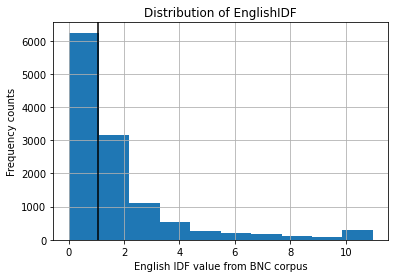

In [104]:
plt.figure()
plt.title("Distribution of EnglishIDF")
plt.xlabel("English IDF value from BNC corpus")
plt.ylabel("Frequency counts")
q1trainfeatureset2['EnglishIDF'].hist()
plt.axvline(q1trainfeatureset2['EnglishIDF'].median(),color='black')
plt.show()

Imputing:

In [105]:
medianIDF = q1trainfeatureset2['EnglishIDF'].median()
q1trainfeatureset2.loc[q1trainfeatureset2['EnglishIDF'].isna(),'EnglishIDF'] = medianIDF

Checking for any null values left post imputing:

In [106]:
q1trainfeatureset2.isna().sum().sum()

0


Applying the same transformations to the test set lexemes:

In [107]:
len(q1test_lexemelist)

2776

In [108]:
# transforming the language column based on already fit one hot encoder:
q1test_lang = pd.DataFrame(enc_lang.transform(np.array(q1testlexemes['learning_language']).reshape(-1, 1)),index=q1testlexemes.index)

# get one hot encoded part of speech:
q1test_pos = pd.DataFrame(enc_pos.transform(np.array(q1testlexemes['pos']).reshape(-1, 1)),index=q1testlexemes.index)


In [109]:
# explode values of list so a separate record is created for each element of the list. 
q1testlexemes['modstrings'].explode()
#enc_mods.fit(np.array(q1trainlexemes['modstrings'].explode()).reshape(-1,1))
q1test_mods_exploded =enc_mods.transform(np.array(q1testlexemes['modstrings'].explode()).reshape(-1,1))

q1test_modsdf_exploded = pd.DataFrame(q1test_mods_exploded, index = q1testlexemes['modstrings'].explode().index)

# group the exploded one-hot dataframe by the q1lexemes index, sum up the exploded records (since one word can have many modifiers in its list)
q1test_modsdf = q1test_modsdf_exploded.groupby(q1test_modsdf_exploded.index).sum()
#np.concatenate([np.array(q1trainlexemes['modstrings'].explode().index).reshape(-1,1),q1train_mods],axis=1)

In [110]:
q1test_modsdf.shape, q1testlexemes.shape

((2776, 86), (2776, 317))

The summed shape of the mods dataframe is the same length as the q1trainlexemes dataframe. 

Now the language, pos and mod sparse columns are combined along with numerical word features to make the first feature set. 

In [111]:
q1testfeatureset2 = pd.concat([q1testlexemes[['sf_length', 'L_dist_sf_noaccents_norm', 'EnglishIDF','lexeme_id'] + list(range(0,300))],
                                q1test_lang, 
                                q1test_pos, 
                                q1test_modsdf, 
                                ],axis=1)

In [112]:
q1testfeatureset2.shape

(2776, 467)

In [113]:
q1testfeatureset2.columns = q1trainfeatureset2.columns

In [114]:
# checking for null values 
q1testfeatureset2.isna().sum()

sf_length                    0
L_dist_sf_noaccents_norm     0
EnglishIDF                  55
lexeme_id                    0
0                            0
                            ..
mod_x0_sp                    0
mod_x0_subj                  0
mod_x0_sup                   0
mod_x0_tn                    0
mod_x0_nan                   0
Length: 467, dtype: int64

Imputing the 55 missing values of EnglishIDF with the train set median:

In [115]:
q1testfeatureset2.loc[q1testfeatureset2['EnglishIDF'].isna(),'EnglishIDF'] = medianIDF

Checking for any null values left post imputing:

In [117]:
q1testfeatureset2.isna().sum().sum()

0

Saving both feature sets:

In [119]:
compressed_pickle(path_name+"Q1TRAIN_lexemesFS2",q1trainfeatureset2)
compressed_pickle(path_name+"Q1TEST_lexemesFS2",q1testfeatureset2)

The number of dimensions matches for train and test post binarizing categorical columns. They are saved as compressed pickle files. 

In [118]:
q1trainfeatureset2.shape, q1testfeatureset2.shape

((12446, 467), (2776, 467))

Estimate of total size of dataset once joined. 

In [58]:
(q1trainfeatureset2.size/10**6)/q1trainfeatureset2.shape[0]*q1train.shape[0] + q1train.size/10**6

3906.151524

The estimated size of a full combined feature set without any dimension reduction is 3.9GB. 

Attempts to combine it all at once failed even with high RAM.

```
# getting lexeme id for the full feature set 1
q1trainfeatureset1['lexeme_id'] = q1trainlexemes.loc[q1trainfeatureset1.index,'lexeme_id']

# joining with main dataframe on lexeme id
q1train_withfs1 = pd.merge(left= q1train,right=q1train,left_on='lexeme_id',right_on = 'lexeme_id',how="left")
```

The workaround of splitting the main dataframe and combining, changing to sparse and stacking did not work (RAM flooded)

## PCA


In [124]:
q1trainfeatureset2 = q1trainfeatureset2.set_index('lexeme_id')

In [125]:
q1trainfeatureset2.head()

,sf_length,L_dist_sf_noaccents_norm,EnglishIDF,0,1,2,3,4,5,6,...,mod_x0_prs,mod_x0_qnt,mod_x0_ref,mod_x0_sg,mod_x0_sint,mod_x0_sp,mod_x0_subj,mod_x0_sup,mod_x0_tn,mod_x0_nan
lexeme_id,,,,,,,,,,,,,,,,,,,,,
73eecb492ca758ddab5371cf7b5cca32,4,0.5,3.733996,-0.269015,-0.041727,-0.045045,0.069940,0.067316,0.135177,-0.383724,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
c84476c460737d9fb905dca3d35ec995,5,0.6,10.981924,-0.007808,0.188679,-0.264520,-0.134410,0.025235,-0.095146,0.455226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1a913f2ded424985b9c02d0436008511,3,0.0,4.051187,0.820083,0.677704,-0.500191,-0.140807,0.549122,0.634742,-0.355794,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
38b770e66595fea718366523b4f7db3f,5,0.8,0.438409,0.020896,0.318951,-0.269169,0.024149,0.415287,0.331545,-0.228645,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
faa6fd18132b358958e440322ee82b4b,3,1.0,0.502649,0.129024,0.423030,-0.457697,0.013778,0.316385,0.414319,0.270645,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Checking for any non-numeric columns left:

In [126]:
q1trainfeatureset2.select_dtypes('object').columns

Index([], dtype='object')

In [135]:
q1trainfeatureset2.shape

(12446, 466)

Data is first scaled to make it mean-centered to prepare it for PCA. 

In [153]:
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()
q1trainfearureset2_ss = stdscaler.fit_transform(q1trainfeatureset2)


from sklearn.decomposition import PCA
pca9 = PCA(n_components=0.9)

# fitting
q1trainfeatureset2_red9 = pca9.fit_transform(q1trainfearureset2_ss)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [154]:
q1trainfeatureset2_red9.shape

(12446, 100)

90% variance explained by just 100 columns. 

We should keep in mind that these are standard scaled, so the other columns in the main dataframe should have a std scaler applied to them prior to joining. 

The loadings are investigated below:

In [158]:
loadings = pd.DataFrame(pca9.components_, columns=q1trainfeatureset2.columns)
loadings

,sf_length,L_dist_sf_noaccents_norm,EnglishIDF,0,1,2,3,4,5,6,...,mod_x0_prs,mod_x0_qnt,mod_x0_ref,mod_x0_sg,mod_x0_sint,mod_x0_sp,mod_x0_subj,mod_x0_sup,mod_x0_tn,mod_x0_nan
0,4.803750e-03,-1.080932e-03,2.837841e-03,5.776775e-02,5.776790e-02,-5.776791e-02,-5.770025e-02,5.776781e-02,-5.729927e-02,-5.775797e-02,...,2.757875e-04,-1.734040e-04,-1.689972e-04,-1.491958e-03,-3.082647e-04,1.514097e-03,-1.034573e-04,-4.588901e-05,-5.888767e-04,8.955891e-04
1,-1.100604e-01,1.403836e-01,-9.650981e-02,7.303431e-05,3.338322e-04,-3.986256e-04,5.715752e-04,3.216017e-04,-8.415568e-03,2.173606e-04,...,7.619867e-02,-1.370110e-02,7.166658e-03,-1.114934e-01,-2.227013e-03,-4.146647e-02,6.325821e-03,2.191874e-04,-9.379826e-03,9.505783e-03
2,-2.248877e-01,2.261170e-01,-4.598120e-02,7.828340e-06,2.123085e-04,-2.495364e-04,-4.702913e-03,2.409151e-04,4.264413e-03,-1.018580e-04,...,-5.908976e-03,3.770637e-02,1.232040e-01,1.939869e-01,1.593828e-02,1.162312e-01,6.096585e-02,4.424417e-03,2.582835e-01,9.499561e-02
3,1.328205e-01,-1.587119e-01,2.373987e-01,3.565336e-04,1.148475e-04,-1.050106e-04,-1.632324e-03,8.674615e-05,3.258129e-03,2.626035e-04,...,1.814421e-02,-1.317711e-02,-2.436018e-02,3.148211e-01,-4.652595e-02,-1.189101e-01,-1.043167e-02,-1.159190e-02,-4.942863e-02,-3.127539e-01
4,1.057000e-02,-9.011936e-02,-3.017214e-02,-3.415637e-05,-1.245002e-04,1.371019e-04,1.084419e-03,-4.836612e-05,-2.190988e-03,2.568150e-04,...,9.192196e-03,2.722766e-03,1.175867e-01,-5.948095e-03,-3.452468e-02,1.440023e-01,3.832373e-02,-8.147917e-03,2.553610e-01,-3.100791e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-1.219853e-06,-1.059657e-06,-2.290706e-06,9.745666e-06,-9.111846e-06,1.427829e-06,-4.244303e-05,9.797361e-06,-4.238805e-05,-2.144673e-04,...,2.537507e-06,-4.350085e-04,6.133300e-04,-3.982180e-05,-1.816411e-06,4.110836e-06,-9.273671e-04,-2.393292e-03,-6.008840e-07,-1.664629e-05
96,3.634098e-07,-2.796816e-06,1.746574e-06,-4.079735e-06,2.816961e-06,-2.985179e-06,-9.753926e-06,2.772413e-07,8.585970e-06,-1.027087e-04,...,1.426722e-06,-1.261531e-04,5.296609e-06,-7.656802e-05,1.679352e-06,-1.795978e-05,-1.912462e-03,1.387523e-03,8.923714e-07,-2.853079e-05
97,-1.936942e-06,-1.669422e-06,-7.713324e-07,-7.298827e-06,-3.036128e-06,9.372286e-06,1.167769e-04,-9.561638e-06,-2.690716e-05,-4.656227e-05,...,1.462176e-06,1.495430e-04,-1.921623e-06,2.940042e-05,1.862406e-06,4.256040e-06,5.760118e-04,-6.974682e-04,-9.377649e-07,1.092160e-05
98,-0.000000e+00,-1.592016e-15,8.180960e-16,-1.211501e-15,-5.825549e-16,1.158785e-15,-1.977229e-14,-1.902431e-15,1.420763e-14,-4.388578e-14,...,2.728217e-16,-1.828852e-13,9.586156e-14,-2.674094e-14,2.149277e-16,-4.905097e-15,-7.336296e-13,1.742826e-12,1.103517e-15,-1.564499e-14


In the above dataframe, each row represents a principal component, starting from the directin of highest variance decreasing to the lowest, until 90% of the variance in the original dataset is explained. 

The loadings in each principal component of each feature in the original dataset is summed up in the series below:

In [159]:
loadingsum = loadings.sum(axis=0)
loadingsum

sf_length                   0.025526
L_dist_sf_noaccents_norm   -0.017580
EnglishIDF                  0.286646
0                           0.058213
1                           0.058893
                              ...   
mod_x0_sp                  -0.802727
mod_x0_subj                -0.233291
mod_x0_sup                  0.813166
mod_x0_tn                  -0.065981
mod_x0_nan                 -0.414299
Length: 466, dtype: float64

In [160]:
loadingsum.abs().sort_values(ascending=False).head(20)

pos_x0_@common_phrases:ca_va_bien    1.776378
pos_x0_@cnj:du_fait_que              1.759146
mod_x0_pron                          1.586753
mod_x0_@prn:quelque_chose            1.568285
pos_x0_@cnj:parce_que                1.547828
pos_x0_@cnj:des_que                  1.544119
mod_x0_@prn:le_meme                  1.497632
pos_x0_@common_phrases:a_demain      1.485157
mod_x0_ind                           1.434816
mod_x0_enc                           1.381238
mod_x0_@present_perfect              1.378514
pos_x0_@cnj:apres_que                1.378390
mod_x0_@prn:celui_la                 1.377853
mod_x0_ant                           1.365204
mod_x0_prn                           1.361853
pos_x0_cnjadv                        1.352992
mod_x0_@formal                       1.346166
lang_x0_it                           1.270985
pos_x0_vbhaver                       1.262025
pos_x0_@neg:pas_du_tout              1.255799
dtype: float64

The components have higher loadings for the part of speech and modifer binary columns. 

In [140]:
pca7 = PCA(n_components=0.7)
# fitting
q1trainfeatureset2_red7 = pca7.fit_transform(q1trainfearureset2_ss)

In [141]:
q1trainfeatureset2_red7.shape

(12446, 13)

The great reduction in number of components for a relatively small reduction in explained variance indicates that there might be a significant amount of collinearity in the binary columns. 

Fot instance, some of the modifiers are only present in certain languages. 

An alternative feature set is considered: FS3, that contains the langugage dummies, pos dummies and word vectors, but the modifier one-hot columns are removed.



In [161]:
q1trainfeatureset3 = q1trainfeatureset2[[col for col in q1trainfeatureset2 if not (str(col).startswith('mod_') or str(col).startswith('pos_'))]]
q1trainfeatureset3.shape

(12446, 308)

Form the original 466 columns, there are 380 columns left after removing the modifier binary columns. 

PCA is done on this third feature set:

In [166]:
stdscaler = StandardScaler()
q1trainfearureset3_ss = stdscaler.fit_transform(q1trainfeatureset3)


from sklearn.decomposition import PCA
pca9 = PCA(n_components=100)

# fitting
q1trainfeatureset3_red9 = pca9.fit_transform(q1trainfearureset3_ss)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [171]:
q1trainfeatureset3_red9.shape

(12446, 100)

In [174]:
pca9.explained_variance_ratio_

array([9.72822510e-01, 5.50439321e-03, 4.37184066e-03, 4.07585138e-03,
       3.89721397e-03, 3.68531055e-03, 2.90948995e-03, 1.49641911e-03,
       3.83061125e-04, 2.15781753e-04, 1.85606755e-04, 1.10446444e-04,
       5.64755342e-05, 5.04020705e-05, 4.37554902e-05, 2.81300521e-05,
       1.76236043e-05, 1.19508171e-05, 1.08805655e-05, 9.54438066e-06,
       8.08067275e-06, 6.89217699e-06, 6.45349157e-06, 5.60792926e-06,
       5.32172148e-06, 4.66479564e-06, 4.60574398e-06, 4.32482616e-06,
       4.06661326e-06, 3.73741445e-06, 3.54947376e-06, 3.11350667e-06,
       2.95912743e-06, 2.74534585e-06, 2.51818811e-06, 2.46480919e-06,
       2.31922394e-06, 2.13644967e-06, 1.91432981e-06, 1.80625546e-06,
       1.68739624e-06, 1.49864718e-06, 1.41847970e-06, 1.35486304e-06,
       1.20513293e-06, 1.16899188e-06, 1.13007149e-06, 1.00000044e-06,
       9.05846441e-07, 8.72125139e-07, 8.25474970e-07, 7.75918684e-07,
       7.53701985e-07, 6.73382878e-07, 6.36395083e-07, 6.27990877e-07,
      

97% of the variance is explained by just the first principal component.

Looking at the loadings:

In [183]:
loading_first_component = pd.DataFrame(pca9.components_[0],index=q1trainfeatureset3.columns)
loading_first_component


,0
sf_length,0.004800
L_dist_sf_noaccents_norm,-0.001076
EnglishIDF,0.002839
0,0.057770
1,0.057771
...,...
lang_x0_en,-0.002322
lang_x0_es,-0.002008
lang_x0_fr,0.000899
lang_x0_it,0.000710


Loadings of language column in first component:

In [185]:
loading_first_component.loc[[ind for ind in loading_first_component.index if str(ind).startswith('lang_')],:]

,0
lang_x0_en,-0.002322
lang_x0_es,-0.002008
lang_x0_fr,0.000899
lang_x0_it,0.000710
lang_x0_pt,0.002767


Loadings of word vectors in first component:

In [188]:
loading_first_component.loc[[ind for ind in loading_first_component.index if type(ind)==int],:]

,0
0,0.057770
1,0.057771
2,-0.057771
3,-0.057703
4,0.057770
...,...
295,0.057272
296,-0.057769
297,0.057762
298,-0.057770


In [189]:
loading_first_component.loc[['EnglishIDF','sf_length','L_dist_sf_noaccents_norm'],:]

,0
EnglishIDF,0.002839
sf_length,0.004800
L_dist_sf_noaccents_norm,-0.001076


It appears that just the word vectors are being represented. 

We will reduce just the word vectors to around 50 columns, and combined with the derived word features of IDF, levenshtein and word length, for the second featureset. 

In [190]:
q1train_vectors_only = q1trainfeatureset2[[col for col in q1trainfeatureset2.columns if type(col)==int]]

In [191]:
q1train_vectors_only.shape

(12446, 300)

PCA to reduce to 50 components.

In [206]:
stdscaler = StandardScaler()
q1train_vectors_only_ss = stdscaler.fit_transform(q1train_vectors_only)


from sklearn.decomposition import PCA
pca_vectors_only = PCA(n_components=20)

# fitting
q1train_vecs = pca_vectors_only.fit_transform(q1train_vectors_only_ss)
q1train_vecs = pd.DataFrame(q1train_vecs,index=q1train_vectors_only.index)
q1train_vecs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
lexeme_id,,,,,,,,,,,,,,,,,,,,
73eecb492ca758ddab5371cf7b5cca32,-1.479945,-0.030556,0.298429,-0.222701,0.021525,-0.082350,-0.045993,0.039523,0.048605,-0.086556,0.013250,0.025168,-0.012956,0.006396,-0.013712,-0.046602,0.031118,0.006337,-0.022328,0.036536
c84476c460737d9fb905dca3d35ec995,-1.491590,-0.099870,0.117657,-0.001287,0.103669,-0.111745,0.020349,0.080407,0.036805,0.025947,0.019593,0.052589,-0.041085,0.031443,0.018741,0.025835,0.048392,0.004428,0.001244,0.036001
1a913f2ded424985b9c02d0436008511,-1.539365,0.056805,-0.322041,0.120513,-0.022774,-0.016248,-0.017513,-0.332716,-0.039060,-0.005725,0.046025,0.068479,0.126669,-0.044556,-0.002113,0.104250,0.035571,-0.007927,-0.053901,0.020444
38b770e66595fea718366523b4f7db3f,-1.515906,-0.042695,-0.118140,0.044631,0.094940,0.128514,-0.049396,-0.186567,0.198649,0.121732,-0.063734,-0.024520,-0.039866,-0.035972,-0.006096,0.005581,0.095154,-0.004338,0.008275,-0.013140
faa6fd18132b358958e440322ee82b4b,-1.498606,-0.036745,-0.143273,-0.023157,0.054643,0.160397,-0.209076,-0.061633,-0.083070,-0.023424,-0.036397,-0.064442,-0.064128,-0.009733,0.031801,-0.017645,0.030858,0.030928,0.021029,0.062665


Dropping extraneous columns from q1train, and q1trainfeatureset1

In [208]:
q1trainfeatureset4 = pd.merge(left = q1trainfeatureset2[['EnglishIDF','sf_length','L_dist_sf_noaccents_norm']],right=q1train_vecs,how="left",right_index=True, left_index=True)

In [209]:
q1trainfeatureset4.shape

(12446, 23)

The columns needed for merging with lexemes for q1train_X: delta, lexeme_id, history_seen, history_frac, simoverdiff, 

The columns needed for q1train_y: p_forgot_bin


In [216]:
q1train_X = q1train[['lexeme_id','delta','history_seen','history_frac','simoverdiff',]]

q1train_y = q1train['p_forgot_bin']

In [217]:
q1train_X.columns

Index(['lexeme_id', 'delta', 'history_seen', 'history_frac', 'simoverdiff'], dtype='object')

In [218]:
q1train_X.isna().sum()

lexeme_id       0
delta           0
history_seen    0
history_frac    0
simoverdiff     0
dtype: int64

All other non-numerical columns have been dropped. 

Merging q1train_X and q1trainfeatureset4

In [219]:
q1train_X4 = pd.merge(left = q1train_X,right=q1trainfeatureset4,how="left",left_on = 'lexeme_id',right_index=True)

In [220]:
q1train_X4.shape

(8070561, 28)

Combining test set similarly:

In [221]:
q1test_vectors_only = q1testfeatureset2[[col for col in q1testfeatureset2.columns if type(col)==int]]

In [222]:
q1test_vectors_only.shape

(2776, 300)

In [223]:
# transform with std scaler and PCA

q1test_vectors_only_ss = stdscaler.transform(q1test_vectors_only)


from sklearn.decomposition import PCA
pca_vectors_only = PCA(n_components=20)

# fitting
q1test_vecs = pca_vectors_only.fit_transform(q1test_vectors_only_ss)
q1test_vecs = pd.DataFrame(q1test_vecs,index=q1test_vectors_only.index)
q1test_vecs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
23,-1.366357,-0.121765,0.282459,-0.112891,0.072199,-0.155650,-0.058429,0.020008,0.002860,-0.049278,0.057129,-0.019453,0.009037,-0.001110,-0.009885,0.015470,-0.039924,-0.018742,0.004855,-0.019293
26,-1.312778,-0.844684,-0.080055,0.233270,0.222186,-0.146283,0.054360,0.076761,0.020825,-0.066904,0.051562,0.054523,-0.023573,0.244493,0.087351,-0.036084,0.027143,-0.018312,-0.006508,-0.037210
30,-1.392530,0.021422,-0.242432,-0.074025,-0.089048,0.003402,0.082626,-0.195476,-0.137162,0.037278,0.013813,0.011601,0.024339,-0.036953,-0.041535,-0.034381,0.039607,0.058248,-0.052162,0.034341
41,-1.404764,-0.170103,0.031976,0.621581,-0.182285,0.186289,0.044171,-0.108554,-0.022361,-0.041205,-0.051607,-0.033038,0.002263,-0.032289,-0.006227,0.012838,-0.009732,0.016435,0.035814,-0.061946
50,-1.389476,1.105090,-0.177252,0.069358,-0.212080,-0.119515,-0.054130,0.105851,0.208040,-0.065247,0.026019,0.109338,-0.129122,0.094372,0.060245,-0.096237,0.034341,0.059933,-0.042863,0.036443


In [224]:
q1testfeatureset4 = pd.merge(left = q1testfeatureset2[['EnglishIDF','sf_length','L_dist_sf_noaccents_norm']],right=q1test_vecs,how="left",right_index=True, left_index=True)

In [225]:
q1testfeatureset4.shape

(2776, 23)

The columns needed for merging with lexemes for q1train_X: delta, lexeme_id, history_seen, history_frac, simoverdiff, 

The columns needed for q1train_y: p_forgot_bin


In [226]:
q1test_X = q1test[['lexeme_id','delta','history_seen','history_frac','simoverdiff',]]

q1test_y = q1test['p_forgot_bin']

In [227]:
q1test_X.columns

Index(['lexeme_id', 'delta', 'history_seen', 'history_frac', 'simoverdiff'], dtype='object')

In [228]:
q1test_X.isna().sum()

lexeme_id       0
delta           0
history_seen    0
history_frac    0
simoverdiff     0
dtype: int64

All other non-numerical columns have been dropped. 

Merging q1train_X and q1trainfeatureset4

In [229]:
q1test_X4 = pd.merge(left = q1train_X,right=q1trainfeatureset4,how="left",left_on = 'lexeme_id',right_index=True)

In [230]:
q1test_X4.shape

(8070561, 28)

In [ ]:
compressed_pickle("Q1TRAIN_pipe4",q1train_X4)
compressed_pickle("Q1TEST_pipe4",q1test_X4)

compressed_pickle("Q1TRAIN_Y_pipe4",q1train_y)
compressed_pickle("Q1TEST_Y_pipe4",q1test_y)


In [ ]:
compressed_pickle(path_name+"q1fs4_column_names",q1trainfeatureset4.columns)

## <font color = 'cornflowerblue' size=4>Conclusions and Next Steps</font>

Word based features have been joined to the Q1 train and test dataframes, and stored as compressed sparse matrices. 

scaling will be done before modeling. 

Next steps:

For pipe1:

Further split q1train_featureset1 into training and validation sets (90-10) split. 

1. Model with classical machine learning techniques
- downsample or upsample or adjust class weight hyperparameter
- logistic regression
- decision tree
- Naive Bayes classification
- downsampled kNN
- doensampled SVM

2. Ensemble techniques
- Random Forest
- AdaBoost
- XGBoost

3. Neural net
- Dense neural net. 

Model performance of pipe1 will be compared with validation set performance average precision and ROC AUC, with a baseline model with no word based features. 



In [ ]:
q1train_X.columns

Index(['lexeme_id', 'delta', 'history_seen', 'history_frac', 'simoverdiff'], dtype='object')